In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Step 1: Import and Explore the Data
data = pd.read_csv(r"C:\Users\chand\Downloads\signal-data.csv")
print("Dataset Shape:", data.shape)
print(data.info())
# print(data.describe())
print("Missing Values:\n", data.isnull().sum())

# Step 2: Data Cleansing
# Drop columns with more than 90% missing values
data_cleaned = data.dropna(axis=1, thresh=0.9 * len(data))

# Select only numeric columns for filling missing values
numeric_cols = data_cleaned.select_dtypes(include=np.number).columns
# Fill remaining missing values with the mean for numeric columns only
for col in numeric_cols:
    data_cleaned.loc[:, col] = data_cleaned.loc[:, col].fillna(data_cleaned.loc[:, col].mean())


Dataset Shape: (1567, 592)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 592 entries, Time to Pass/Fail
dtypes: float64(590), int64(1), object(1)
memory usage: 7.1+ MB
None
Missing Values:
 Time          0
0             6
1             7
2            14
3            14
             ..
586           1
587           1
588           1
589           1
Pass/Fail     0
Length: 592, dtype: int64



Univariate Analysis:

Analysis for column: 0
count    1567.000000
mean     3014.452896
std        73.480613
min      2743.240000
25%      2966.665000
50%      3011.840000
75%      3056.540000
max      3356.350000
Name: 0, dtype: float64


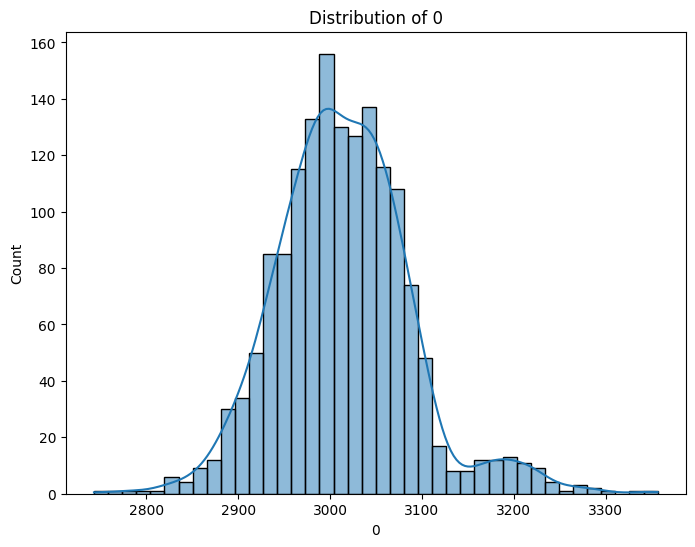


Analysis for column: 1
count    1567.000000
mean     2495.850231
std        80.227793
min      2158.750000
25%      2452.885000
50%      2498.910000
75%      2538.745000
max      2846.440000
Name: 1, dtype: float64


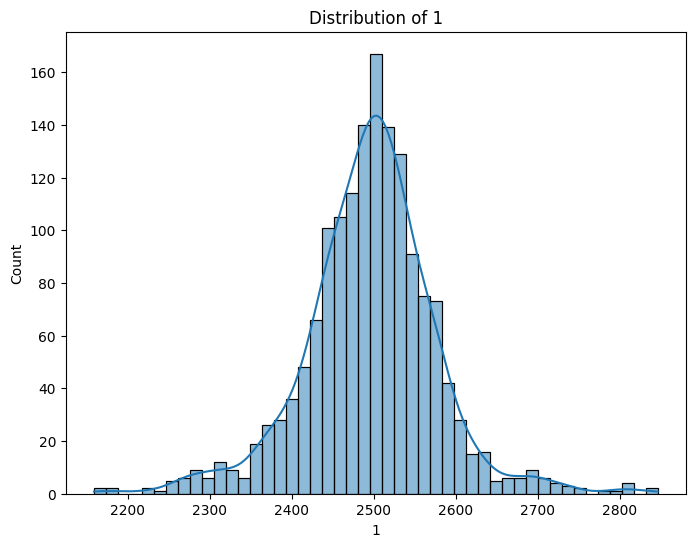


Bivariate Analysis:

Analysis for columns: 0 vs 1


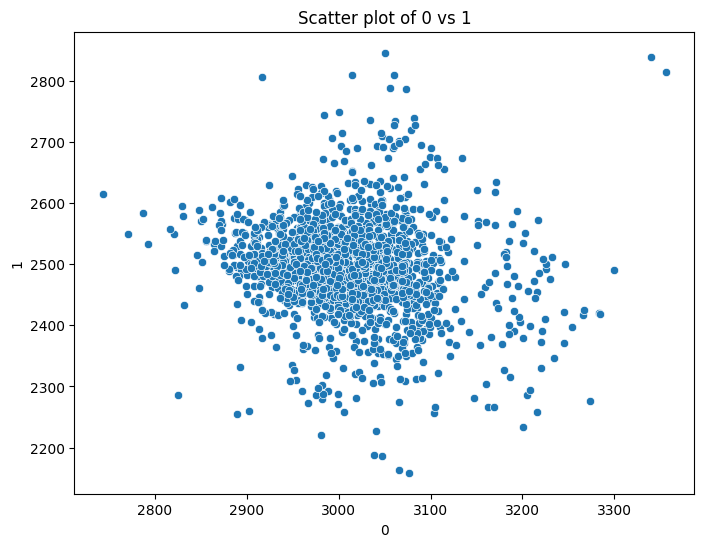

         0        1
0  1.00000 -0.14384
1 -0.14384  1.00000

Analysis for columns: 0 vs 2


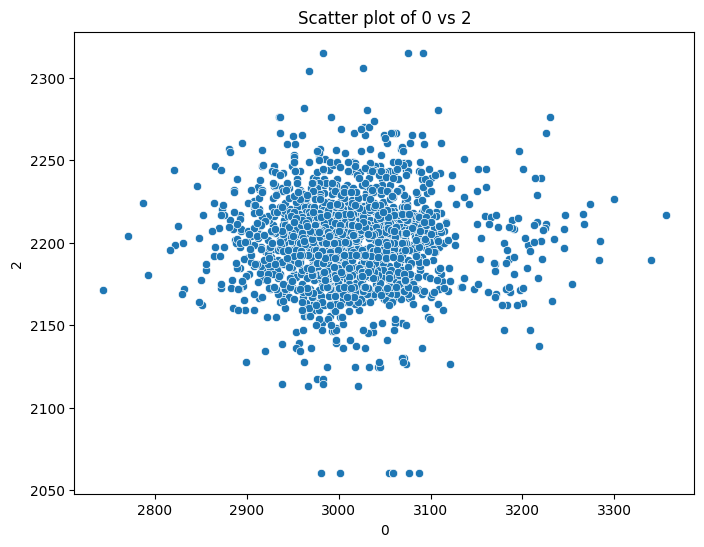

          0         2
0  1.000000  0.004756
2  0.004756  1.000000
first loop


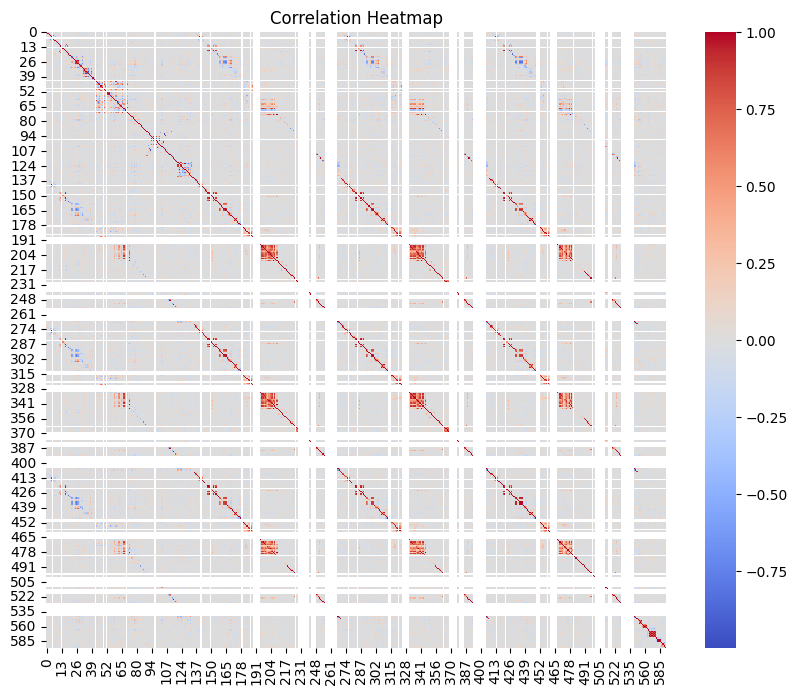

In [5]:
# 3. Data analysis & visualisation:

#Univariate Analysis
print("\nUnivariate Analysis:")
i=1
for col in data_cleaned.select_dtypes(include=np.number).columns:
    print(f"\nAnalysis for column: {col}")
    print(data_cleaned[col].describe())
    plt.figure(figsize=(8, 6))
    sns.histplot(data_cleaned[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()
    i=i+1
    if(i==3):
      break

# Bivariate Analysis
print("\nBivariate Analysis:")
numeric_cols = data_cleaned.select_dtypes(include=np.number).columns
i=1
for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 != col2:
            print(f"\nAnalysis for columns: {col1} vs {col2}")
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=data_cleaned[col1], y=data_cleaned[col2])
            plt.title(f'Scatter plot of {col1} vs {col2}')
            plt.show()
            print(data_cleaned[[col1, col2]].corr())
            if(i==2):
              break
            i=i+1
    print("first loop")
    break


# # Multivariate Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(data_cleaned.select_dtypes(include=np.number).corr(), cmap="coolwarm", annot=False)
plt.title('Correlation Heatmap')
plt.show()



In [6]:
# 4. Data pre-processing:

# Segregate predictors and target
X = data_cleaned.drop('Pass/Fail', axis=1)
y = data_cleaned['Pass/Fail']

# Identify and drop non-numeric columns from X
# Assuming 'Time' is the problematic column containing date/time data, but adjust as needed
non_numeric_cols = X.select_dtypes(exclude=np.number).columns
X = X.drop(columns=non_numeric_cols)

# Check for target imbalance and apply SMOTE
if y.value_counts().min() / y.value_counts().max() < 0.3:  # Example threshold, adjust as needed
    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)

# Perform train-test split and standardization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check statistical characteristics (example: mean and standard deviation)
print("Original data mean:", data_cleaned.select_dtypes(include=np.number).mean())
print("Original data std:", data_cleaned.select_dtypes(include=np.number).std())
print("Train data mean:", pd.DataFrame(X_train, columns = X.columns).select_dtypes(include=np.number).mean())
print("Train data std:", pd.DataFrame(X_train, columns = X.columns).select_dtypes(include=np.number).std())
print("Test data mean:", pd.DataFrame(X_test, columns = X.columns).select_dtypes(include=np.number).mean())
print("Test data std:", pd.DataFrame(X_test, columns = X.columns).select_dtypes(include=np.number).std())

Original data mean: 0            3014.452896
1            2495.850231
2            2200.547318
3            1396.376627
4               4.197013
                ...     
586             0.021458
587             0.016475
588             0.005283
589            99.670066
Pass/Fail      -0.867262
Length: 539, dtype: float64
Original data std: 0             73.480613
1             80.227793
2             29.380932
3            439.712852
4             56.103066
                ...    
586            0.012354
587            0.008805
588            0.002866
589           93.861936
Pass/Fail      0.498010
Length: 539, dtype: float64
Train data mean: 0      7.150975e-16
1      6.285570e-16
2     -8.676061e-15
3      2.064825e-16
4     -9.109522e-18
           ...     
585    1.577086e-16
586    1.913000e-16
587    3.036507e-18
588   -1.070369e-16
589   -4.554761e-17
Length: 538, dtype: float64
Train data std: 0      1.000214
1      1.000214
2      1.000214
3      1.000214
4      1.000214
     

In [ ]:
# 5. Model training, testing and tuning:

# Import regression metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Function to train and evaluate a model
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Use regression metrics for Linear Regression
    if model_name == "Linear Regression":
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{model_name} Mean Squared Error: {mse:.4f}")
        print(f"{model_name} R-squared: {r2:.4f}")
    else:
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{model_name} Accuracy: {accuracy:.4f}")

    # Cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Use appropriate scoring for cross-validation
    if model_name == "Linear Regression":
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        print(f"{model_name} Cross-Validation Scores (Negative MSE): {cv_scores}")
        print(f"{model_name} Mean CV Score (Negative MSE): {np.mean(cv_scores):.4f}")
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
        print(f"{model_name} Cross-Validation Scores: {cv_scores}")
        print(f"{model_name} Mean CV Score: {np.mean(cv_scores):.4f}")

    # Only print classification report for classification models
    if model_name != "Linear Regression":
        print(classification_report(y_test, y_pred))

    return model  # Return the trained model

# Linear Regression
linear_reg = LinearRegression()
linear_reg_model = train_and_evaluate(linear_reg, "Linear Regression", X_train, y_train, X_test, y_test)

y_pred_linear = linear_reg_model.predict(X_test)
linear_reg_r2 = r2_score(y_test, y_pred_linear)

# Logistic Regression
logistic_reg = LogisticRegression(max_iter=1000) # Increased max_iter to ensure convergence
logistic_reg_model = train_and_evaluate(logistic_reg, "Logistic Regression", X_train, y_train, X_test, y_test)

y_pred_logistic = logistic_reg_model.predict(X_test)
logistic_reg_accuracy = accuracy_score(y_test, y_pred_logistic)

# KNN
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3,5,7,9,11]}
grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
knn_best = grid_search_knn.best_estimator_
knn_model = train_and_evaluate(knn_best, "KNN", X_train, y_train, X_test, y_test)

y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

# Model Comparison
print("\nModel Comparison:")
models = {
    "Linear Regression": (linear_reg_r2, linear_reg_model),
    "Logistic Regression": (logistic_reg_accuracy, logistic_reg_model),
    "KNN": (knn_accuracy, knn_model)
}

for name, (accuracy, model) in models.items():
    print(f"{name}: Accuracy = {accuracy:.4f}")

# Select the best model (Example: based on accuracy)
best_model_name = max(models, key=lambda k: models[k][0])
best_model = models[best_model_name][1]
print(f"\nBest Model: {best_model_name}")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')